In [629]:
!pip install tensorflow==2.10.0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Activation, Permute, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv3D
from tensorflow.keras.layers import SeparableConv2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
import tensorflow as tf
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
from pandas import DataFrame as df
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
    
def CompleteModel(months, lats,lons , featureNum, spatialKernelShape = (4,4),
            S1 = 2, norm_rate = 0.25,):
    temporalKernelShape = (1,1)
    input1   = Input(shape = (lats,lons, months * featureNum))
    
    ##################################################################
    block1 = BatchNormalization()(input1)
    block1 = AveragePooling2D((4, 4), padding='valid',strides = (1,1))(block1)
    # Spatial Informaiton Extraction
    block1 = DepthwiseConv2D(depth_multiplier = 1,kernel_size = spatialKernelShape, padding = 'same',strides = (1,1))(block1)
    block1 = AveragePooling2D((4, 4),padding='valid',strides = (4,4))(block1)
    block1 = BatchNormalization()(block1)
    # Temporal Information Extraction
    block1 = Conv2D(filters = featureNum*2,groups = 2,kernel_size = temporalKernelShape, padding = 'same',strides = (1,1))(block1)
    block1 = Activation('leaky_relu')(block1)
    block1 = AveragePooling2D((4, 4),padding='same',strides = (1,1))(block1)
        
    #block2 = SeparableConv2D(S1, (2,2),
    #                               use_bias = False, padding = 'same')(block1)
    block2 = Conv2d(filters = 4, )
    block2       = Activation('leaky_relu')(block2)
    flatten = Flatten()(block2)
    
    dense1 = Dense(10,activation = 'leaky_relu')(flatten)
    dense2 = Dense(1, activation = 'linear',use_bias = True)(dense1)
    
    return Model(inputs=input1, outputs=dense2)




[notice] A new release of pip available: 22.2.1 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [377]:
from numpy.random import seed
seed(0)
tf.random.set_seed(0)

In [454]:
# Read Data
feat = pd.read_csv("../Data/MERRA2/NormalizedFeatures.csv").drop(['Unnamed: 0'],axis = 1)
TCcount = pd.read_csv("../Data/TC Count/IBTrACS/IBTrACS(1980-P, 100W-20W&10N-40N).csv")
feat['time'] = pd.to_datetime(feat['time'])
feat = feat.loc[(feat['time'].dt.month <= 5) & (feat['time'].dt.year > 1980) & (feat['time'].dt.year < 2022)]
TCcount = TCcount.loc[(TCcount['SEASON'] > 1980) & (TCcount['SEASON'] < 2022)]

In [455]:
feat

,time,lon,lat,OMEGA500,SLP,U500,SSSMASS,month,year
86559,1981-01-01,-100.0,10.0,0.682125,0.398674,0.235564,0.150067,1,1981
86560,1981-01-01,-100.0,10.5,0.681483,0.402729,0.239629,0.156719,1,1981
86561,1981-01-01,-100.0,11.0,0.680792,0.406284,0.244860,0.163706,1,1981
86562,1981-01-01,-100.0,11.5,0.680263,0.409389,0.252569,0.169086,1,1981
86563,1981-01-01,-100.0,12.0,0.680129,0.412352,0.262794,0.174016,1,1981
...,...,...,...,...,...,...,...,...,...
3903019,2021-05-01,-20.0,38.0,0.704109,0.694664,0.442277,0.054698,5,2021
3903020,2021-05-01,-20.0,38.5,0.700855,0.689762,0.454413,0.057722,5,2021
3903021,2021-05-01,-20.0,39.0,0.697471,0.683551,0.466451,0.061900,5,2021
3903022,2021-05-01,-20.0,39.5,0.693790,0.676209,0.478088,0.066258,5,2021


In [456]:
# reshaped inputs to years * number of features times number of months * longitudes * latitudes
# in every year (3D dataset), features (2D layer) across months are stacked together. 
# i.e., first 5 layers are the OMEGA500 from Jan to May in that year, 6-10 are SLP, 11-15 are U500, etc.
coordinations = len(np.unique(feat['lon'])) * len(np.unique(feat['lat']))
years = np.unique(feat['year'])
months = np.unique(feat['month'])
lons = np.unique(feat['lon'])
lats = np.unique(feat['lat'])
featuresNum = 4
features = ['OMEGA500','SLP','U500','SSSMASS']
x = np.zeros((len(years),featuresNum * len(months),len(lons),len(lats)))
for yearIndex in range(len(years)):
    tempDF = feat.loc[feat['year'] == years[yearIndex]]
    for featIndex in range(featuresNum):
        x[yearIndex,featIndex * len(months) : (featIndex + 1)*len(months)] = tempDF[features[featIndex]].to_numpy().reshape(len(months),len(lons),len(lats))

In [457]:
# sanity check
x[3,5,3,4] == feat.loc[(feat['year'] == years[3]) & (feat['month'] == months[0]) 
                       & (feat['lon'] == lons[3]) 
                       & (feat['lat'] == lats[4])]['SLP']
x = x.transpose(0,3,2,1)

370030    True
Name: SLP, dtype: bool

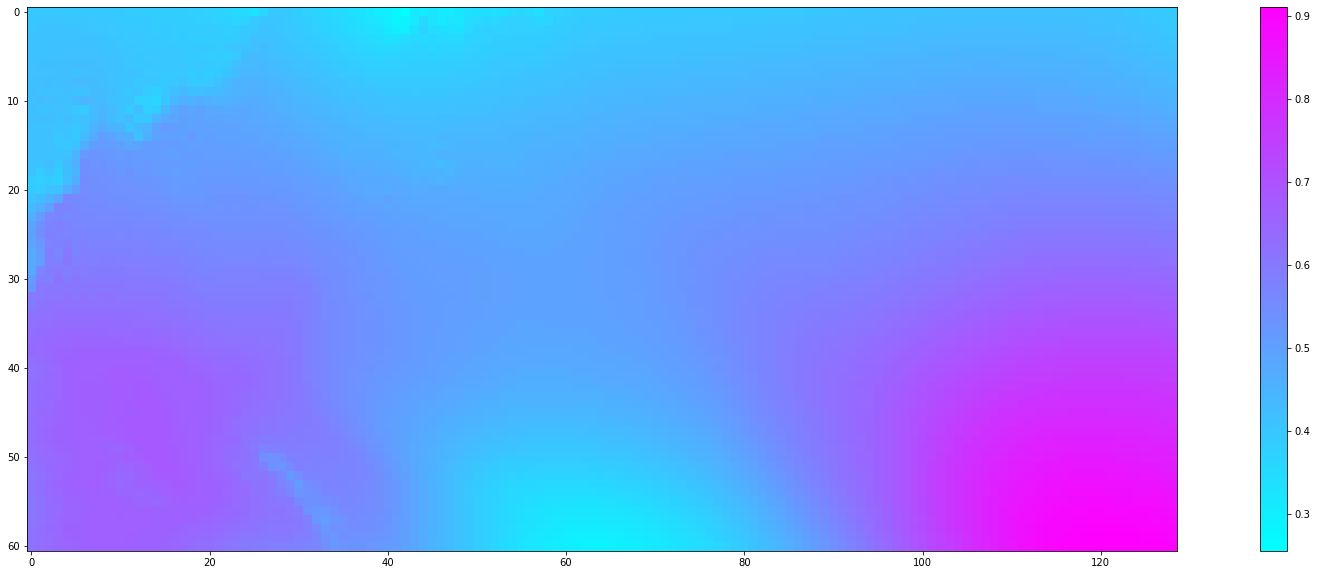

In [630]:
plt.figure(figsize=(30,10))
plt.imshow(x[0,:,:,5], cmap='cool')
plt.colorbar()
plt.show()

In [631]:
def AlternateModel(months, lats,lons , featureNum, spatialKernelShape = (20,20),
            S1 = 4, norm_rate = 0.25,):
    temporalKernelShape = (1,1)
    input1   = Input(shape = (lats,lons, months * featureNum))
    
    ##################################################################
    block1 = AveragePooling2D((4, 4), padding='valid',strides = (1,1))(input1)
    # Spatial Informaiton Extraction
    block1 = DepthwiseConv2D(depth_multiplier = 1,
                             kernel_size = spatialKernelShape, 
                             padding = 'same',
                             strides = (1,1),
                            )(block1)
    block1 = AveragePooling2D((4, 4),padding='same',strides = (1,1))(block1)
    # Temporal Information Extraction
    block1 = Conv2D(filters = 10,groups = 1,
                    kernel_size = temporalKernelShape,
                    padding = 'same',strides = (1,1),
                   )(block1)
    block1 = Activation('leaky_relu')(block1)
    block1 = AveragePooling2D((4, 4),padding='valid',strides = (4,4))(block1)
        
    block2 = SeparableConv2D(S1, 
                             (2,2),
                             use_bias = False, 
                             padding = 'same',
                            )(block1)
    block2 = Activation('leaky_relu')(block2)
    block2 = MaxPooling2D((4,8),padding = 'valid',strides = (4,8))(block2)
    flatten = Flatten()(block2)
    
    dense1 = Dense(10,activation = 'leaky_relu')(flatten)
    dense2 = Dense(5, activation = 'leaky_relu',use_bias = True)(dense1)
    dense3 = Dense(1, activation = 'linear',use_bias = True)(dense2)
    
    return Model(inputs=input1, outputs=dense3)

def TestModel(months, lats,lons , featureNum, spatialKernelShape = (6,6),
            S1 = 4, norm_rate = 0.25,):
    temporalKernelShape = (1,1)
    input1   = Input(shape = (lats,lons, months * featureNum))
    
    ##################################################################
    block1 = AveragePooling2D((4, 4), padding='valid',strides = (1,1))(input1)
    # Spatial Informaiton Extraction
    block1 = DepthwiseConv2D(depth_multiplier = 1,
                             kernel_size = spatialKernelShape, 
                             padding = 'same',
                             strides = (1,1),
                            )(block1)
    block1 = AveragePooling2D((4, 4),padding='same',strides = (1,1))(block1)
    # Temporal Information Extraction
    block1 = Conv2D(filters = 1,groups = 1,
                    kernel_size = temporalKernelShape,
                    padding = 'same',strides = (1,1),
                   )(block1)
    block1 = Activation('leaky_relu')(block1)
    block1 = AveragePooling2D((4, 4),padding='valid',strides = (4,4))(block1)
        
    block2 = SeparableConv2D(S1, 
                             (2,2),
                             use_bias = False, 
                             padding = 'same',
                            )(block1)
    block2 = Activation('leaky_relu')(block2)
    block2 = MaxPooling2D((4,8),padding = 'valid',strides = (4,8))(block2)
    flatten = Flatten()(block2)
    
    dense1 = Dense(10,activation = 'leaky_relu')(flatten)
    dense2 = Dense(5, activation = 'leaky_relu',use_bias = True)(dense1)
    dense3 = Dense(1, activation = 'linear',use_bias = True)(dense2)
    
    return Model(inputs=input1, outputs=dense3)


In [625]:
model = AlternateModel(len(months),len(lats),len(lons),featuresNum)

optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer,loss='mse',metrics=[tf.keras.metrics.MeanSquaredError()])
#y = (TCcount['COUNT']-TCcount['COUNT'].min())/(TCcount['COUNT'].max()-TCcount['COUNT'].min())
y = TCcount['COUNT']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.10)
es = EarlyStopping(monitor='mean_squared_error', verbose=1, patience = 20,min_delta = 0.001)
hist = model.fit(X_train, y_train,batch_size=10,epochs = 5, verbose=1,validation_data= (X_test,y_test),callbacks = [es])

In [626]:
model.summary()

Model: "model_58"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_73 (InputLayer)       [(None, 61, 129, 20)]     0         
                                                                 
 average_pooling2d_159 (Aver  (None, 58, 126, 20)      0         
 agePooling2D)                                                   
                                                                 
 depthwise_conv2d_60 (Depthw  (None, 58, 126, 20)      8020      
 iseConv2D)                                                      
                                                                 
 average_pooling2d_160 (Aver  (None, 58, 126, 20)      0         
 agePooling2D)                                                   
                                                                 
 conv2d_70 (Conv2D)          (None, 58, 126, 10)       210       
                                                          

Epoch 1/5


/Users/jackzhang/opt/anaconda3/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


4/4 [==============================] - 1s 254ms/step - loss: 255.3829 - mean_squared_error: 255.3829 - val_loss: 165.0163 - val_mean_squared_error: 165.0163
Epoch 2/5
4/4 [==============================] - 1s 202ms/step - loss: 74.5422 - mean_squared_error: 74.5422 - val_loss: 86.1545 - val_mean_squared_error: 86.1545
Epoch 3/5
4/4 [==============================] - 1s 219ms/step - loss: 74.2844 - mean_squared_error: 74.2844 - val_loss: 51.9988 - val_mean_squared_error: 51.9988
Epoch 4/5
4/4 [==============================] - 1s 224ms/step - loss: 63.0759 - mean_squared_error: 63.0759 - val_loss: 43.8466 - val_mean_squared_error: 43.8466
Epoch 5/5
4/4 [==============================] - 1s 205ms/step - loss: 34.4005 - mean_squared_error: 34.4005 - val_loss: 16.4127 - val_mean_squared_error: 16.4127


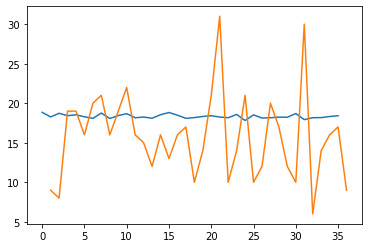

In [627]:
from sklearn.preprocessing import StandardScaler

plt.plot(model.predict(X_train))
plt.plot(np.arange(1,37,1),y_train)

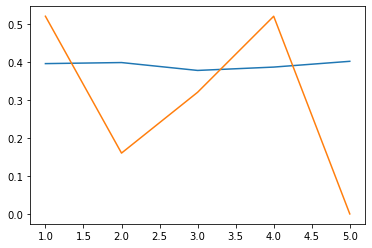

In [620]:
plt.plot(np.arange(1,6,1),model.predict(X_test))
plt.plot(np.arange(1,6,1),y_test)

In [621]:
X_test.shape

(5, 61, 129, 20)

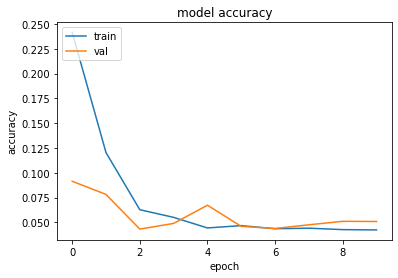

In [622]:
plt.plot(np.array(hist.history['mean_squared_error'])[-35:])
plt.plot(np.array(hist.history['val_mean_squared_error'])[-35:])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [320]:
np.array(hist.history['val_mean_squared_error'])[-5:]

array([78.80335999, 74.04756927, 80.42557526, 73.61119843, 77.44730377])

In [565]:
model.layers[7].get_weights()

[array([[[[ 0.661319  ]],
 
         [[-0.35793173]]],
 
 
        [[[-0.21272582]],
 
         [[ 0.5123921 ]]]], dtype=float32),
 array([[[[ 0.80362797, -0.579483  ,  0.9202604 , -0.13999724]]]],
       dtype=float32)]

In [561]:
model.layers

In [632]:
feat

,time,lon,lat,OMEGA500,SLP,U500,SSSMASS,month,year
86559,1981-01-01,-100.0,10.0,0.682125,0.398674,0.235564,0.150067,1,1981
86560,1981-01-01,-100.0,10.5,0.681483,0.402729,0.239629,0.156719,1,1981
86561,1981-01-01,-100.0,11.0,0.680792,0.406284,0.244860,0.163706,1,1981
86562,1981-01-01,-100.0,11.5,0.680263,0.409389,0.252569,0.169086,1,1981
86563,1981-01-01,-100.0,12.0,0.680129,0.412352,0.262794,0.174016,1,1981
...,...,...,...,...,...,...,...,...,...
3903019,2021-05-01,-20.0,38.0,0.704109,0.694664,0.442277,0.054698,5,2021
3903020,2021-05-01,-20.0,38.5,0.700855,0.689762,0.454413,0.057722,5,2021
3903021,2021-05-01,-20.0,39.0,0.697471,0.683551,0.466451,0.061900,5,2021
3903022,2021-05-01,-20.0,39.5,0.693790,0.676209,0.478088,0.066258,5,2021
